# Przygotowanie środowiska
Import wymaganych bibliotek

In [1]:
import datetime
import os
import json


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
from sklearn.metrics import ndcg_score

from keras.initializers import RandomNormal
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Embedding,
    Flatten,
    Input,
    Multiply,
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

import optuna

2025-01-22 18:51:45.083799: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/david/anaconda3/envs/ML39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import własnych funkcji

In [2]:
from utils import *
from model_architectures.NeuMF import *

## Dane

Dane zostały wstępnie obrobione, i zapisane w folderze `datasets`  
- Informacje dotyczące wstępnej obróbki datasetu znajdują się w pliku `./datasets/parse_datasets.ipynb`
- Informacje dotyczące sposobu załadowania danych znajdują się w pliku `./utils.py`

**Wczytanie danych**
- treningowych
- testowych
- listy urzytkowników
- listy itemów

In [3]:
train_data, test_data, users_all, items_all = load_dataset(dataset_path="./datasets/ml-latest-small")

for (label, data) in [["train_data",train_data],["test_data",test_data]]:
  print(f"{label}:")
  display(data)

train_dataset = to_dataset(train_data, batch_size=2048*6)

train_data:


,interaction,item_id,user_id
0,0,5481,447
1,1,3672,88
2,0,8711,211
3,0,8603,274
4,0,3819,602
...,...,...,...
1108570,1,1598,297
1108571,0,756,452
1108572,0,3852,90
1108573,0,5523,481


test_data:


,interaction,item_id,user_id
0,0,3051,380
1,0,5238,280
2,0,2308,199
3,0,5303,542
4,0,4682,607
...,...,...,...
61605,0,2495,523
61606,0,9235,487
61607,0,255,67
61608,0,1831,435


2025-01-22 18:51:47.298444: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-01-22 18:51:47.299474: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-01-22 18:51:47.311571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-22 18:51:47.311742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.759GHz coreCount: 10 deviceMemorySize: 5.92GiB deviceMemoryBandwidth: 178.99GiB/s
2025-01-22 18:51:47.311765: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-01-22 18:51:47.335163: I tensorflow/stream_executor/platfor

# NeuMF

## Model
Wczytanie modelu z pliku:

In [4]:
with open("./model_architectures/NeuMF_hiper_params.json", "r") as json_file:
  hiper_params = json_file.read()
  
hiper_params = json.loads(hiper_params)

hiper_params["n_users"] = len(users_all)
hiper_params["n_items"] = len(items_all)
model = create_model_NeuMF(hiper_params)

## Trening
Callback urzywane w trakcie szkolenia:
- `TensorBoard` - włączenie obsługi TensorBoarda
- `EarlyStoppingAtNDGC` - własny callback zatrzymujący szkolenie kiedy `NDGC@10` modelu przez `patience` epok nie rośnie

`make_metrics_vs_epochs_graphs()` - na koniec treningu wyświetla statystyki metryk względem epok

**Kompilacja modelu i trening:**

2025-01-22 18:51:48.503861: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 18:51:48.503887: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 18:51:48.504525: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2025-01-22 18:51:48.509814: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2025-01-22 18:51:48.610818: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2025-01-22 18:51:48.611093: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100


2025-01-22 18:51:49.805019: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-01-22 18:51:49.823080: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2025-01-22 18:51:50.121767: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


 2/91 [..............................] - ETA: 4s - loss: 168.4991 - accuracy: 0.4839 - auc: 0.4998 - precision: 0.0933 - recall: 0.5252 - tp: 797.0000 - fp: 7748.5000 - tn: 8977.0000 - fn: 909.5000  

2025-01-22 18:51:50.450625: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 18:51:50.450657: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 18:51:50.451336: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2025-01-22 18:51:50.468630: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 18:51:50.492263: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 18:51:50.499764: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 18:51:50.567244: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-185148/train/plugins/profile

91/91 [==============================] - 4s 25ms/step - loss: 95.9513 - accuracy: 0.8780 - auc: 0.5267 - precision: 0.0933 - recall: 0.0397 - tp: 800.9130 - fp: 7786.1630 - tn: 511560.4130 - fn: 50901.5326
Epoch 2/100
91/91 [==============================] - 2s 22ms/step - loss: 5.0615 - accuracy: 0.9095 - auc: 0.8418 - precision: 0.0000e+00 - recall: 0.0000e+00 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 519344.1522 - fn: 51704.8696
Epoch 3/100
91/91 [==============================] - 2s 22ms/step - loss: 0.5855 - accuracy: 0.9139 - auc: 0.8616 - precision: 0.5096 - recall: 0.0782 - tp: 5909.2174 - fp: 2275.8913 - tn: 517071.1087 - fn: 45792.8043
Epoch 4/100
91/91 [==============================] - 2s 22ms/step - loss: 0.3044 - accuracy: 0.9240 - auc: 0.8679 - precision: 0.7231 - recall: 0.2597 - tp: 13418.3587 - fp: 5058.1087 - tn: 514287.7283 - fn: 38284.8261
Epoch 5/100
91/91 [==============================] - 2s 23ms/step - loss: 0.2695 - accuracy: 0.9258 - auc: 0.8796 - precision: 0.

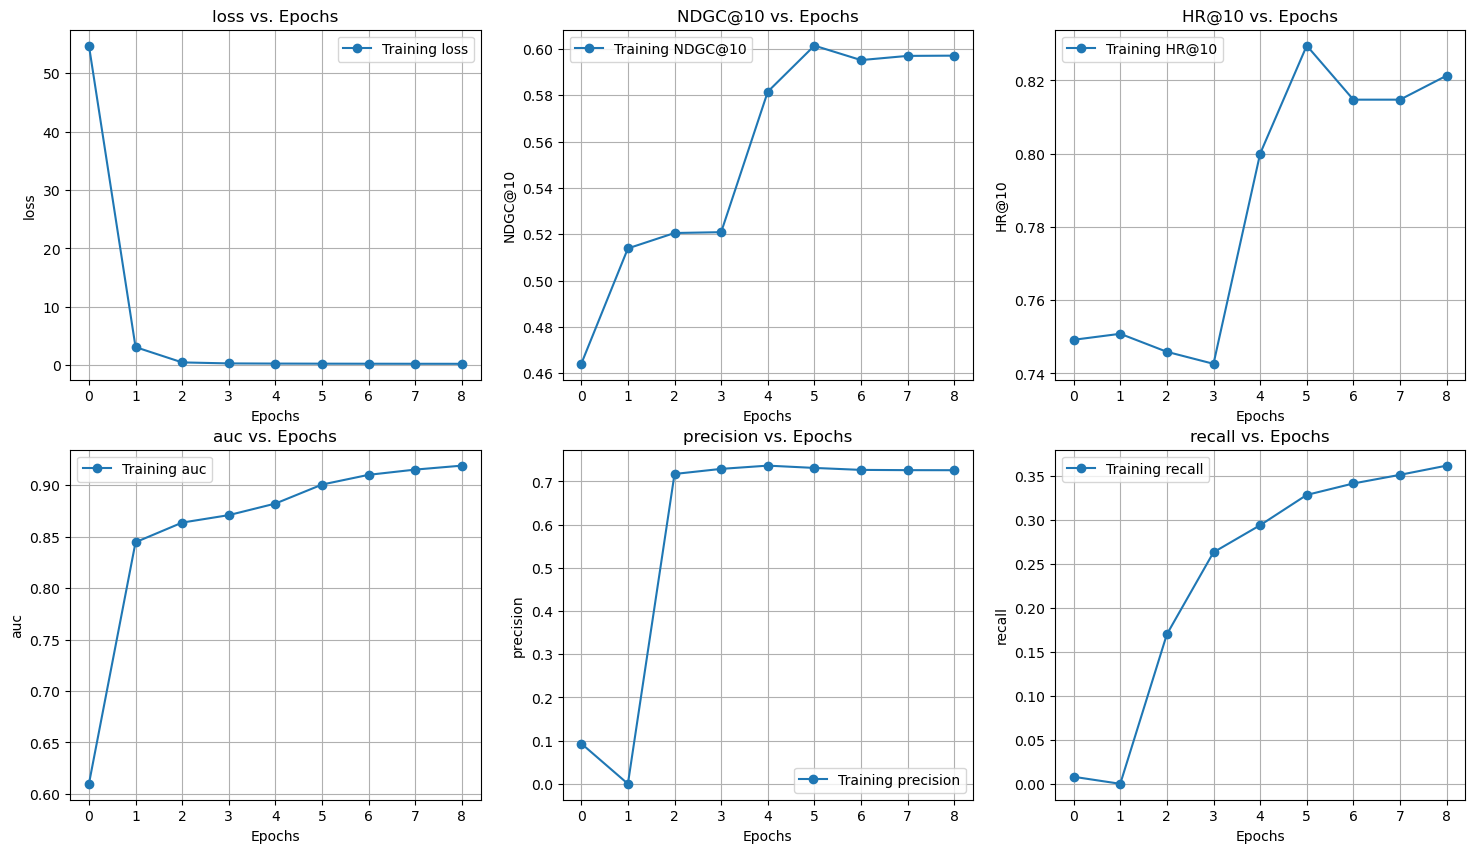

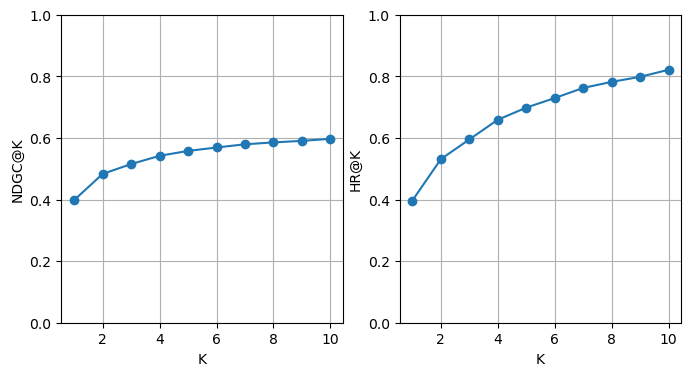

In [ ]:
model.compile(
  optimizer="adam",
  loss="binary_crossentropy",
  metrics=[
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.AUC(name="auc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
  ],
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
earlyStoppingAtNDGC = EarlyStoppingAtNDGC(patience=3, test_data=test_data)

train_hist = model.fit(
  train_dataset,
  epochs=100,
  callbacks=[tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1), earlyStoppingAtNDGC],
  verbose=1
) 
  
model.save("./models/NeuMF-ml-small.keras")

## Ewaluacja modelu

### Metryki na przestrzeni epok

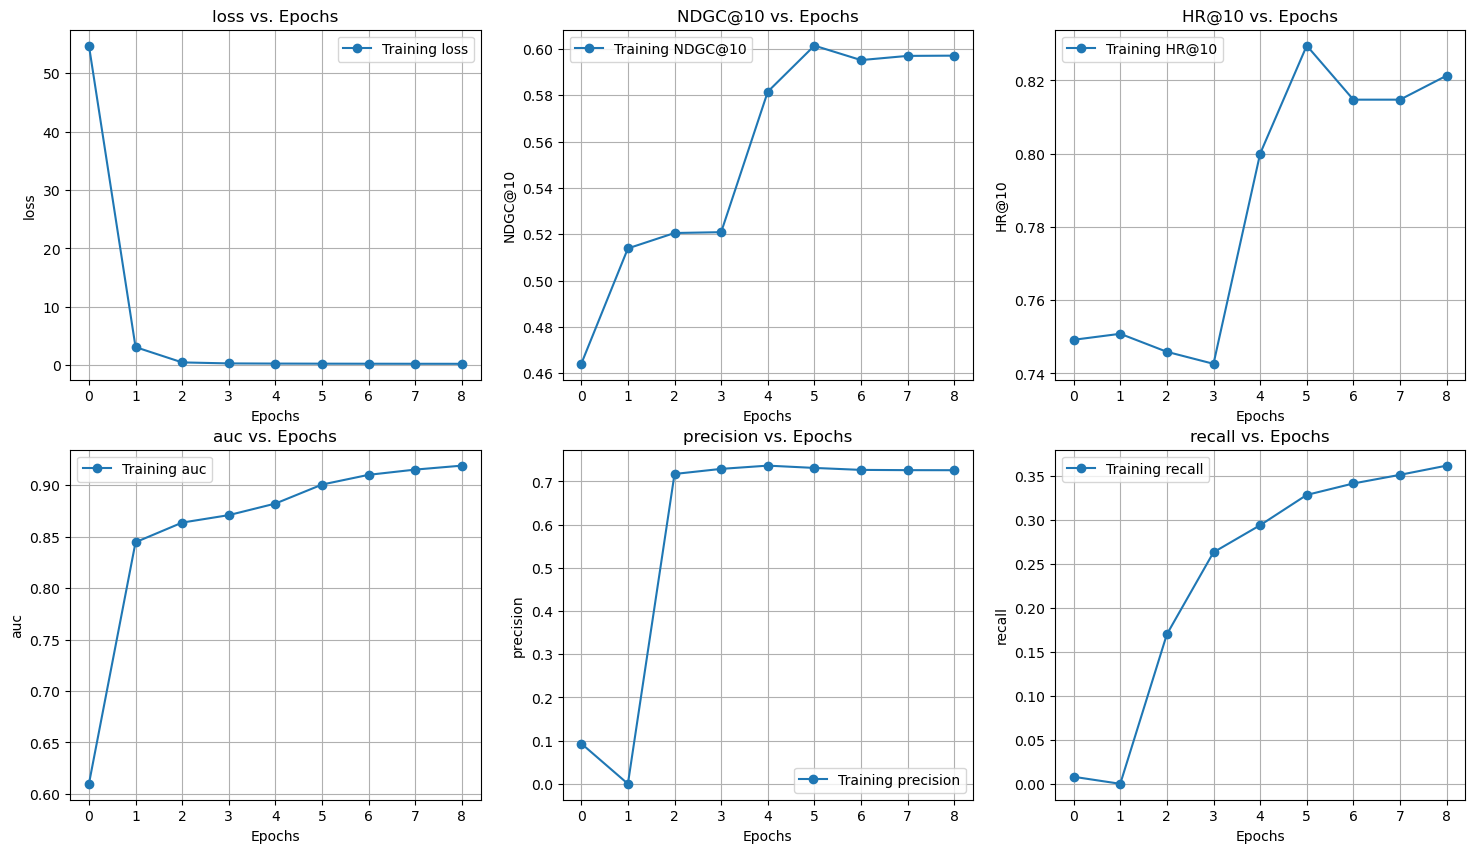

In [8]:
make_metrics_vs_epochs_graphs(train_hist, earlyStoppingAtNDGC)

### Ewaluacja metodą *leave-one-out*

#### Metoda *leave-one-out*
Standard w ewaluacji systemów rekomendacji, polega na stworzenie datasetu testowego poprzez (dla każdego urzytkownika):
- usuwamy ostatnią interakcję z datasetu treningowego i przerzucamy do datasetu testowego
- dodajemy do datasetu testowego 100 itemów z którymi nie zaistniała interakcja

Najpopularniejszymi metrykami w tej metodzie są:
- `HR@K` (Hit Rate at K) - określa w ilu procentach przypadków system przewidział prawdziwą interakcję w K najprawdopodomniejszych predykcjach
- `NDGC@K` (Normalized Discounted Cumulative Gain at K) - wskazuje jak wysoko w K najprawdopodobniejszych predykcjach znajduje się prawdziwa interakcja (1 dla prawdziwej interakcji zawsze na pierwszym miejscu)

#### Ewaluacja

In [1]:
predictions = model.predict([test_data["user_id"].values, test_data["item_id"].values], batch_size=1024*8, verbose=0)
test_data["predictions"] = predictions

td2 = test_data.groupby(['user_id', 'item_id', 'predictions'], as_index=False)['interaction'].max()
y_score = td2.pivot(index='user_id', columns='item_id', values='predictions').fillna(0).values
valid_true = td2[['user_id', 'item_id', 'interaction']].pivot(index='user_id', columns='item_id', values='interaction').fillna(0).values

ndcg_at_k = ndcg_score(valid_true, y_score, k=10)
hr_at_k = calculate_hr_at_k(test_data, k=10)
print(f"NDGC@10: {ndcg_at_k}")
print(f"HR@10: {hr_at_k}")

make_metrics_vs_k_graphs(test_data)


NameError: name 'model' is not defined


|  | Mój NeuMF | Orginalne NeuMF       | Orginalne NeuMF z pretreningiem       |
|-----------------|----------------|----------------|----------------|
| HR@10 | 0.820 | 0.705 | 0.730 |
| NDGC@10 | 0.597 | 0.426 | 0.447 |

\* Orginalne modele były trenowane na pełnym datasecie, przy stałej ilości `latent_dim` równej 64 (najleprze zaraportowane wyniki przez autorów)